# Loan Eligibility & Risk Scoring System
**Goal:** predict the probability that a borrower will **default** on a loan, using applicant profile + loan terms.

**Target:** `Default` (0 = no default, 1 = default)

**Success metrics (primary → secondary):**
- Primary: **F1-score** on the default class (catch defaulters without spamming false positives)
- Secondary: **ROC-AUC**, **precision/recall**, and **PR-AUC**.


In [8]:
#import basic requirements 
# Core
import numpy as np
import pandas as pd

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


import joblib
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Load dataset
df = pd.read_excel("loan_dataset.xlsx")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [11]:
#Dataset rows x columns
print("Dataset shape:", df.shape, "\n")

# Check data types and missing values
print("Dataset Information:\n",df.info(),"\n\n")
print("Checking null data:\n",df.isna().sum())

Dataset shape: (255246, 18) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255246 entries, 0 to 255245
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255246 non-null  object 
 1   Age             255246 non-null  int64  
 2   Income          255246 non-null  int64  
 3   LoanAmount      255246 non-null  int64  
 4   CreditScore     255246 non-null  int64  
 5   MonthsEmployed  255246 non-null  int64  
 6   NumCreditLines  255246 non-null  int64  
 7   InterestRate    255246 non-null  float64
 8   LoanTerm        255246 non-null  int64  
 9   DTIRatio        255246 non-null  float64
 10  Education       255246 non-null  object 
 11  EmploymentType  255246 non-null  object 
 12  MaritalStatus   255246 non-null  object 
 13  HasMortgage     255246 non-null  object 
 14  HasDependents   255246 non-null  object 
 15  LoanPurpose     255246 non-null  object 
 16  HasCoSigner     255246 non

### Target Variable Distribution

Before analyzing features, let’s first look at the distribution of the target variable `Default`.  
This helps us check for class imbalance, which can impact model training and evaluation.


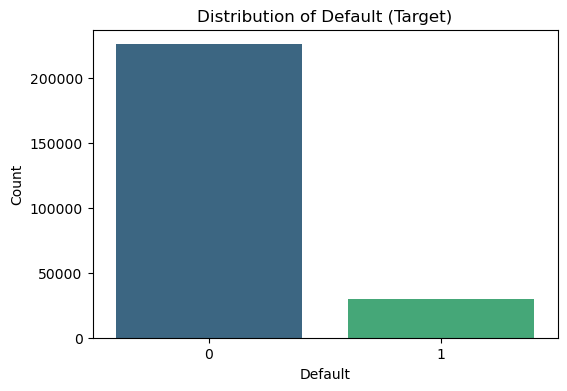

Default
0    0.883861
1    0.116139
Name: proportion, dtype: float64


In [19]:
# Distribution of target variable
plt.figure(figsize=(6,4))
sns.countplot(x=df['Default'], palette="viridis")
plt.title("Distribution of Default (Target)")
plt.xlabel("Default")
plt.ylabel("Count")
plt.show()
print(df['Default'].value_counts(normalize=True))

### Drop irrelevant columns
First we drop irrelevant columns 
- LoadID since it is unique for every person
- Default since it is the target

### Categorical Distributions
This helps us understand how balanced each categorical feature is. 
Here, the categorical values are fairly balanced

In [22]:
# Drop irrelevant columns
X = df.drop(['LoanID', 'Default'], axis=1)
y = df['Default']

# Identify numeric and categorical columns and separate them for EDA and Modeling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Categorical distributions
for col in categorical_features:
    print(f"\n== {col} ==")
    print(df[col].value_counts())


Numeric features: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical features: ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

== Education ==
Education
Bachelor's     64343
High School    63877
Master's       63516
PhD            63510
Name: count, dtype: int64

== EmploymentType ==
EmploymentType
Part-time        64131
Unemployed       63799
Self-employed    63680
Full-time        63636
Name: count, dtype: int64

== MaritalStatus ==
MaritalStatus
Married     85274
Divorced    84999
Single      84973
Name: count, dtype: int64

== HasMortgage ==
HasMortgage
No     127630
Yes    127616
Name: count, dtype: int64

== HasDependents ==
HasDependents
Yes    127683
No     127563
Name: count, dtype: int64

== LoanPurpose ==
LoanPurpose
Business     51281
Home         51262
Education    50983
Other        50897
Auto         50823
Name: count, dtype:

### Univariate Analysis

We start with individual features (numeric & categorical) to understand their distributions.  
- **Numeric features**: Histograms  
- **Categorical features**: Countplots


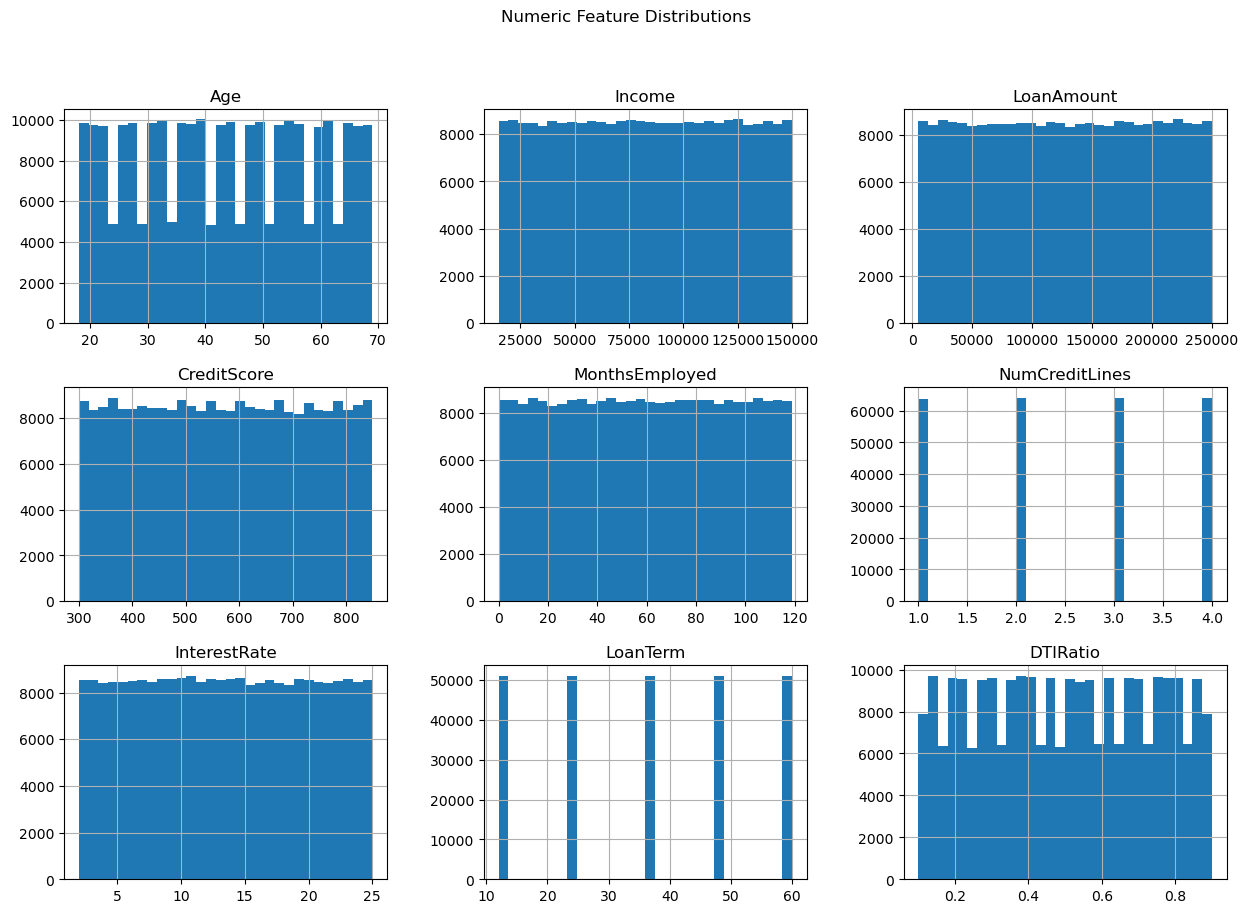

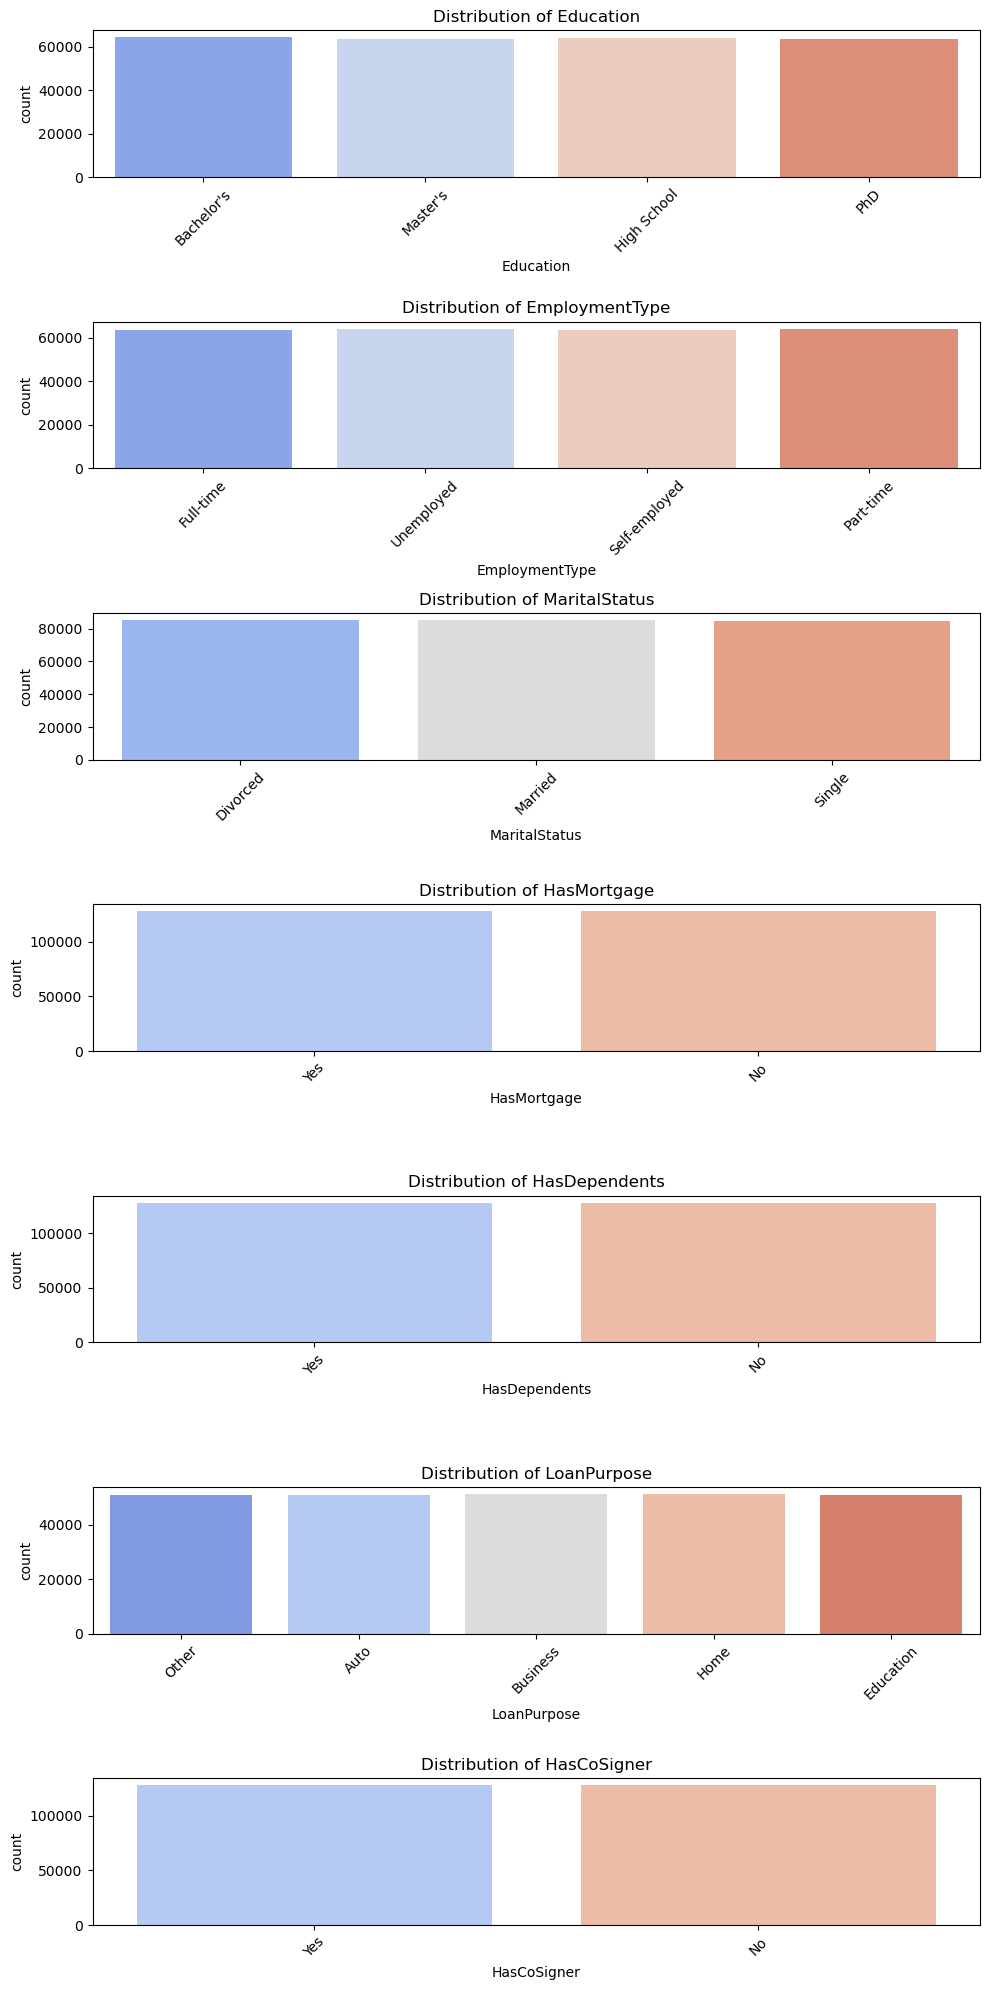

In [42]:
# Numeric features distribution
X[numeric_features].hist(bins=30, figsize=(15,10))
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Categorical features distribution
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(10, 20))
for i, col in enumerate(categorical_features):
    sns.countplot(x=X[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### Bivariate Analysis: Default vs Features

Now, let’s compare how different features vary across the target `Default`.  
- For **categorical features**, we use bar plots of proportions.  
- For **numeric features**, we use boxplots to check distribution shifts between classes.


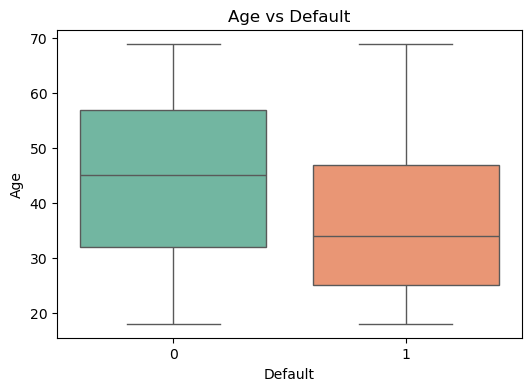

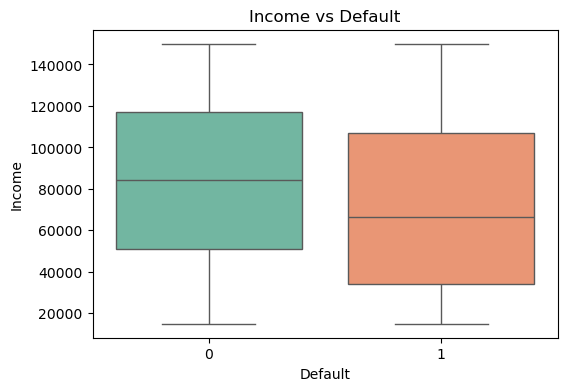

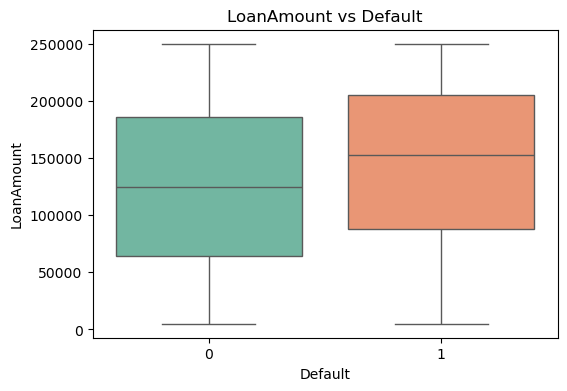

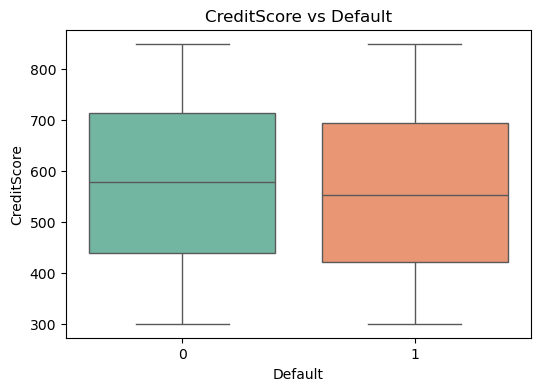

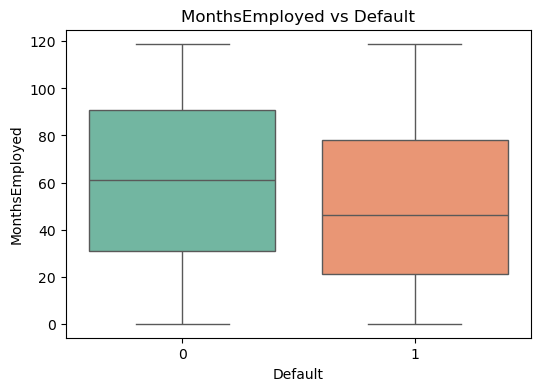

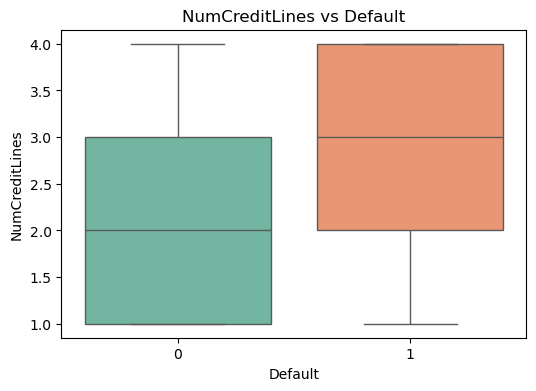

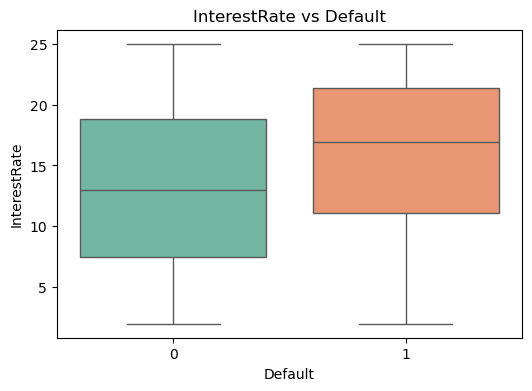

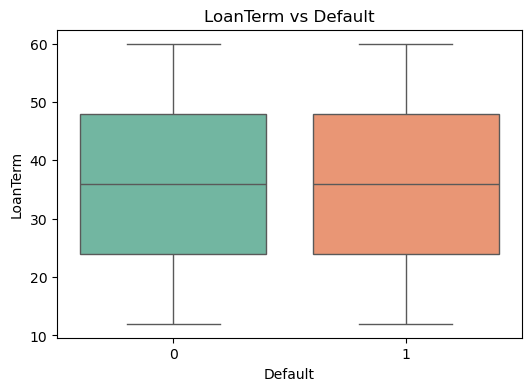

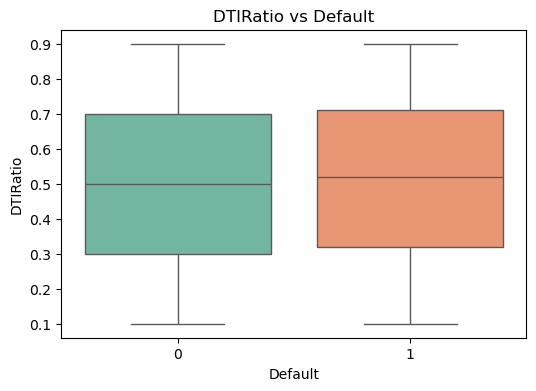

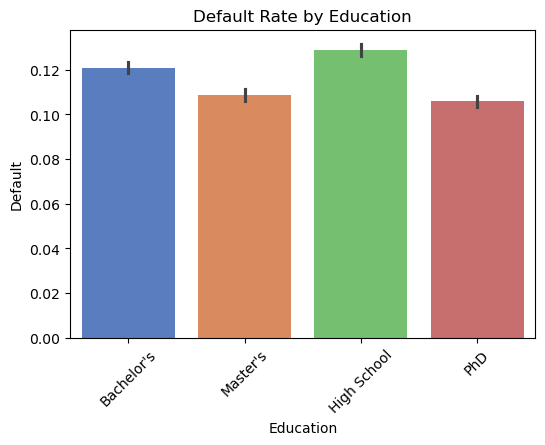

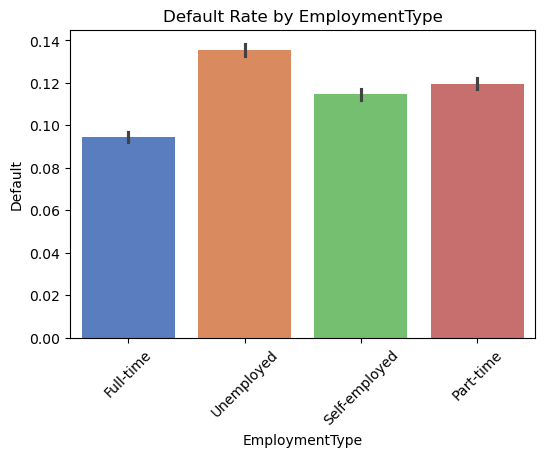

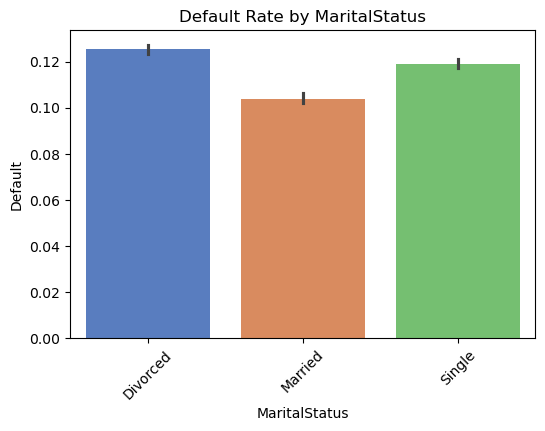

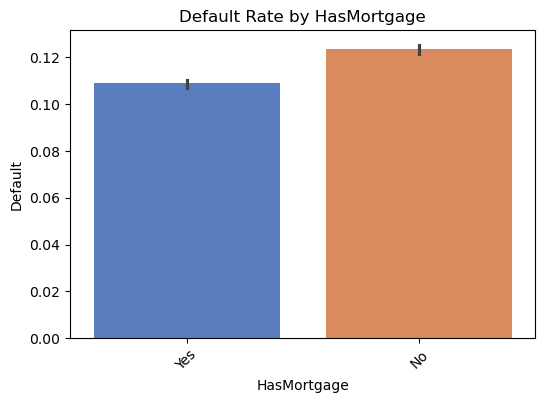

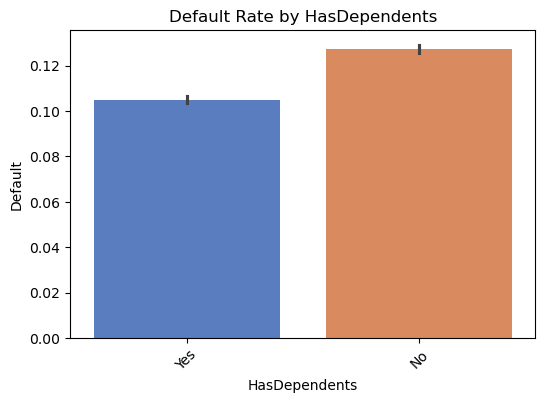

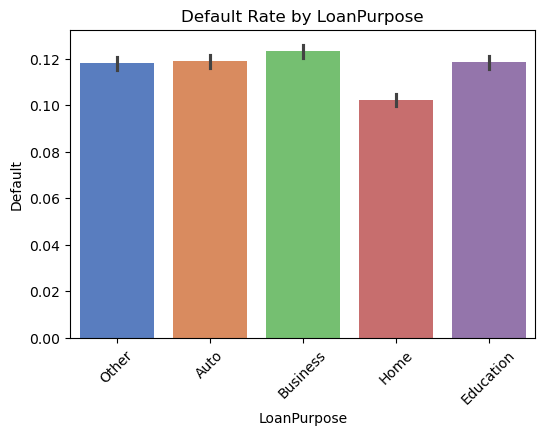

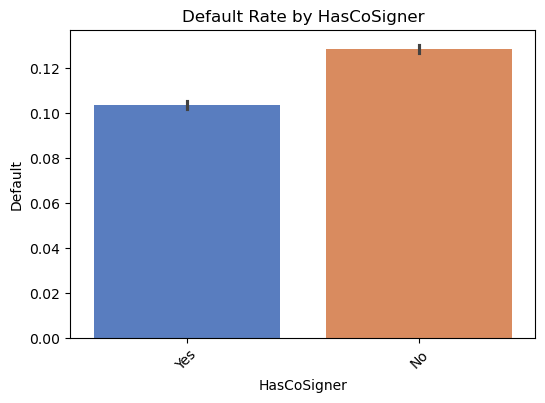

In [45]:
# Boxplots for numeric features
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=y, y=X[col], palette="Set2")
    plt.title(f"{col} vs Default")
    plt.show()

# Proportions for categorical features
for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y=y, data=df, estimator=np.mean, palette="muted")
    plt.title(f"Default Rate by {col}")
    plt.xticks(rotation=45)
    plt.show()

### Multivariate Analysis

Here we explore interactions between multiple features.  
For example:  
- Loan amount relative to income (`LoanIncomeDiff = LoanAmount - Income`).  
- Loan purpose & employment type combinations.  
This helps identify groups of borrowers with higher/lower risk.


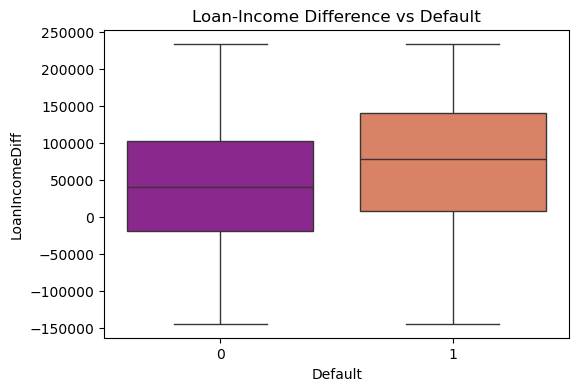

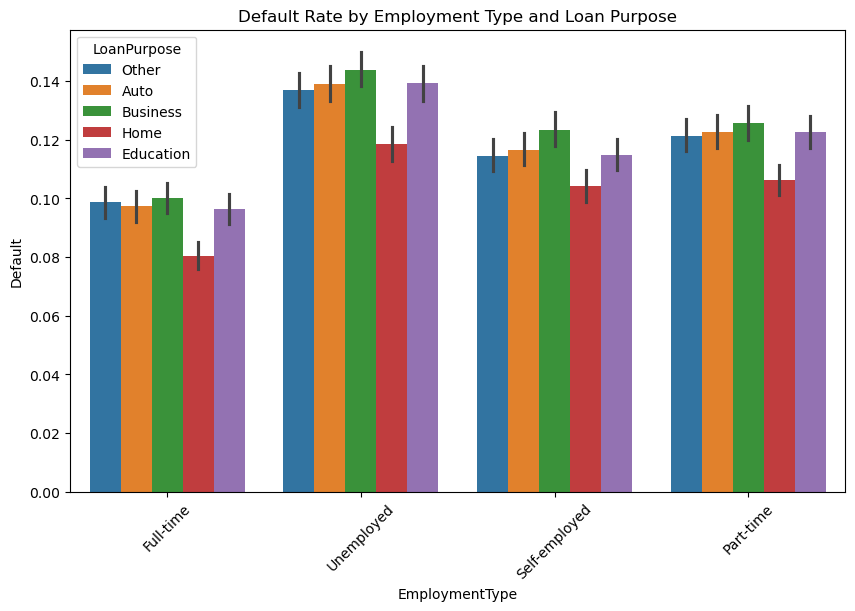

In [48]:
# Example: Loan-Income Difference
df["LoanIncomeDiff"] = df["LoanAmount"] - df["Income"]

plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=df["LoanIncomeDiff"], palette="plasma")
plt.title("Loan-Income Difference vs Default")
plt.show()

# Example: Employment Type + Loan Purpose
plt.figure(figsize=(10,6))
sns.barplot(x="EmploymentType", y="Default", hue="LoanPurpose", data=df, estimator=np.mean)
plt.title("Default Rate by Employment Type and Loan Purpose")
plt.xticks(rotation=45)
plt.show()

### Scatterplots for Numeric Features

Scatterplots help us check whether pairs of numeric features show separability between defaulters and non-defaulters.  
We’ll color the points by `Default`.

- The output is not very useful because of the varying data available

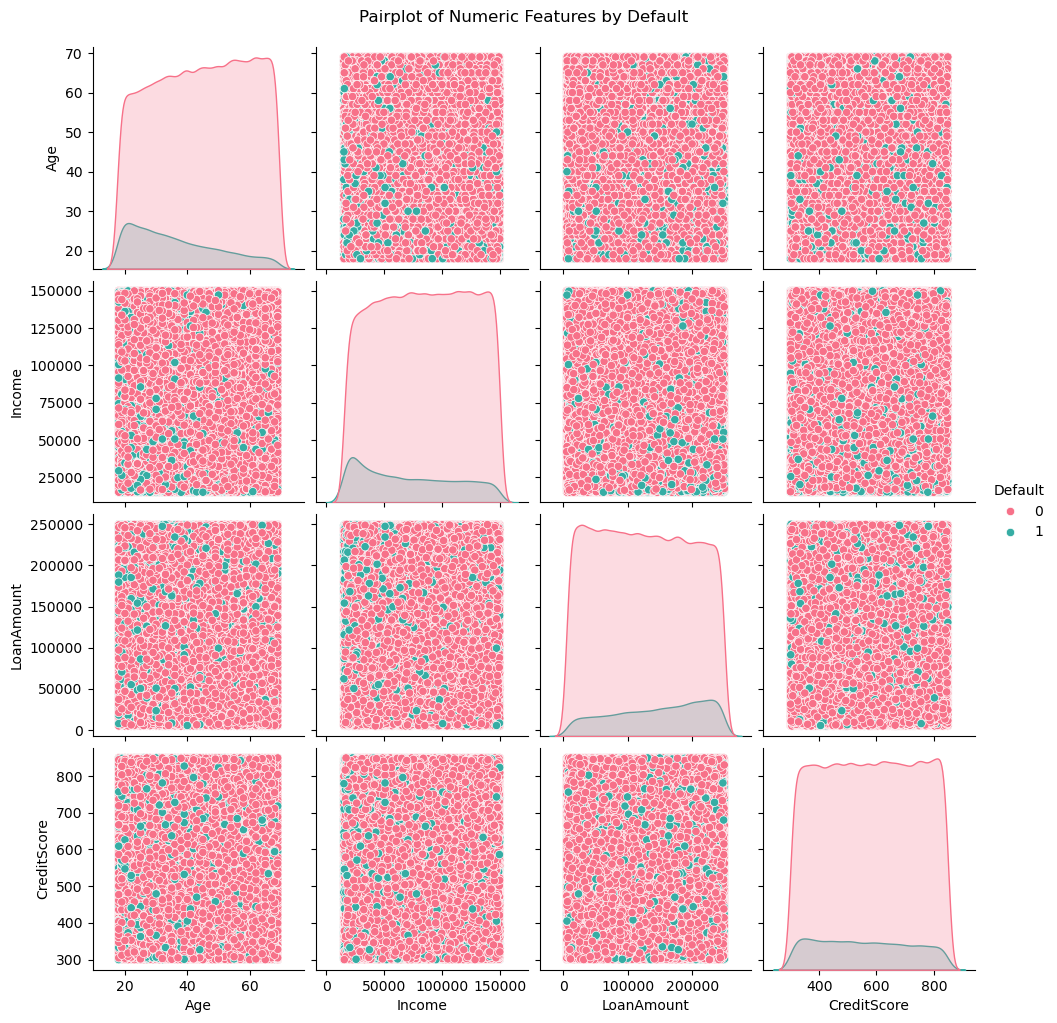

In [51]:
sns.pairplot(df, vars=numeric_features[:4], hue="Default", palette="husl", diag_kind="kde")
plt.suptitle("Pairplot of Numeric Features by Default", y=1.02)
plt.show()

### Grouped Categorical Analysis

Let’s explore how combinations of categorical variables affect default rates.


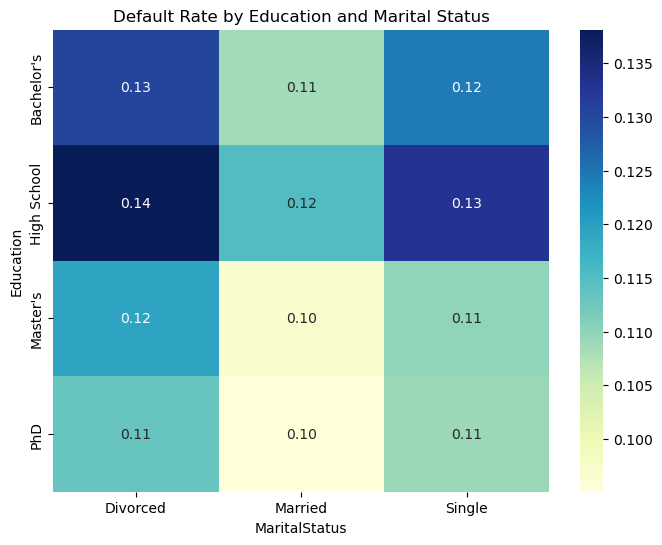

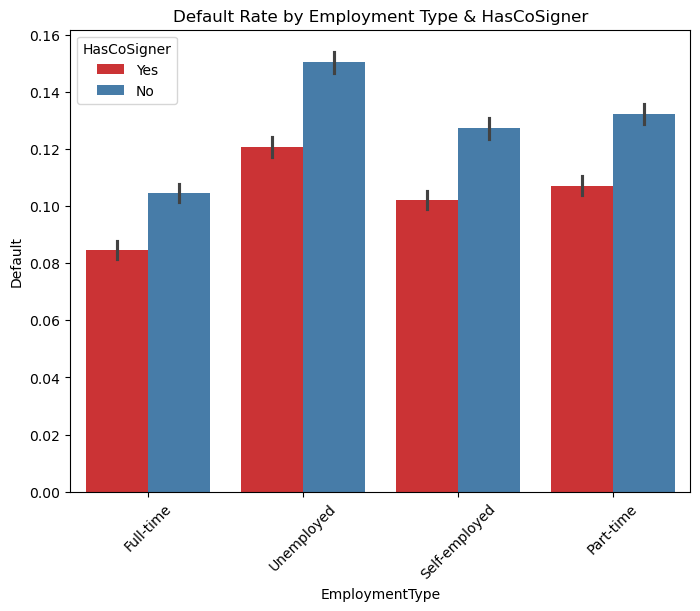

In [59]:
# Example: Education + MaritalStatus
edu_marital = df.groupby(["Education","MaritalStatus"])["Default"].mean().unstack()

plt.figure(figsize=(8,6))
sns.heatmap(edu_marital, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Default Rate by Education and Marital Status")
plt.show()

# Example: EmploymentType + HasCoSigner
plt.figure(figsize=(8,6))
sns.barplot(x="EmploymentType", y="Default", hue="HasCoSigner", data=df, estimator=np.mean, palette="Set1")
plt.title("Default Rate by Employment Type & HasCoSigner")
plt.xticks(rotation=45)
plt.show()

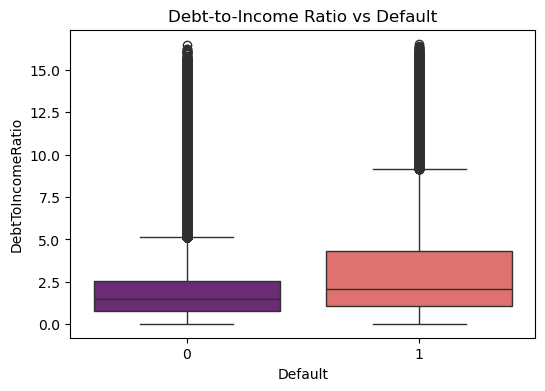

In [83]:
# Debt to Income Ratio
df["DebtToIncomeRatio"] = df["LoanAmount"] / (df["Income"] + 1)  # avoid divide by zero

plt.figure(figsize=(6,4))
sns.boxplot(x="Default", y="DebtToIncomeRatio", data=df, palette="magma")
plt.title("Debt-to-Income Ratio vs Default")
plt.show()


### Loan-to-Income Ratio Analysis

When comparing Loan-to-Income Ratio between defaulters and non-defaulters, we observe:
- Defaulters tend to borrow significantly higher relative to their income, with ratios going as high as 10.
- Non defaulters remain within a safer range, mostly below 2.5.
- This makes Loan-to-Income Ratio a strong indicator of default risk, suggesting that borrowers with >3× income loans are highly vulnerable.

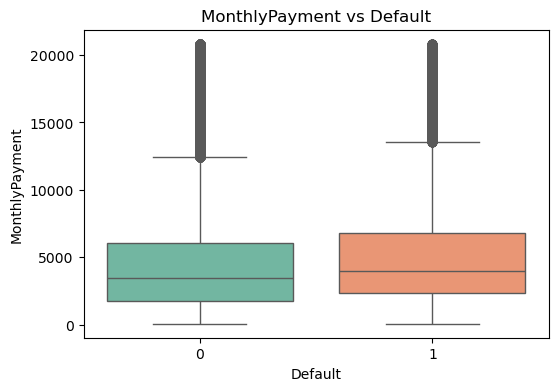

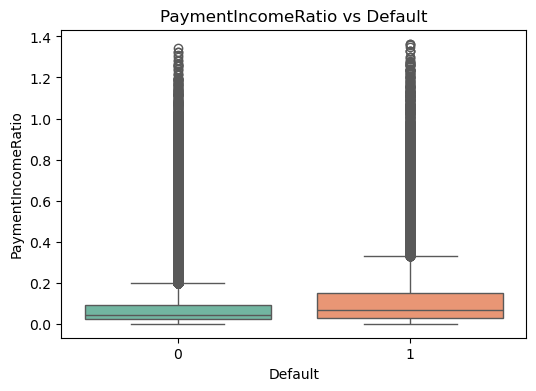

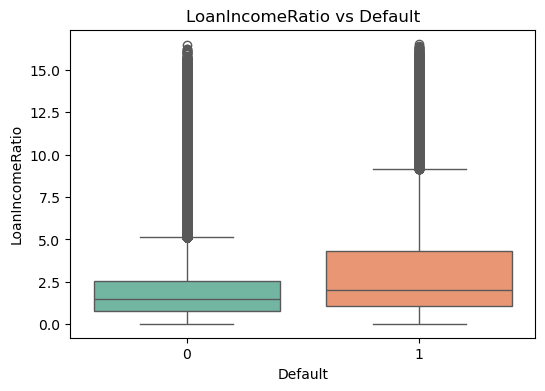

In [76]:
df["MonthlyPayment"] = df["LoanAmount"] / df["LoanTerm"]
df["PaymentIncomeRatio"] = df["MonthlyPayment"] / df["Income"]
df["LoanIncomeRatio"] = df["LoanAmount"] / df["Income"]

for col in ["MonthlyPayment", "PaymentIncomeRatio", "LoanIncomeRatio"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Default", y=col, data=df, palette="Set2")
    plt.title(f"{col} vs Default")
    plt.show()


### Loan Term × Loan Amount × Employment Type

Here we check how loan term and loan size interact with employment type to influence default rates.
- Long-term + large loans + unstable income (part-time/unemployed) are usually riskier.
- This analysis groups by all three and shows average default rate.


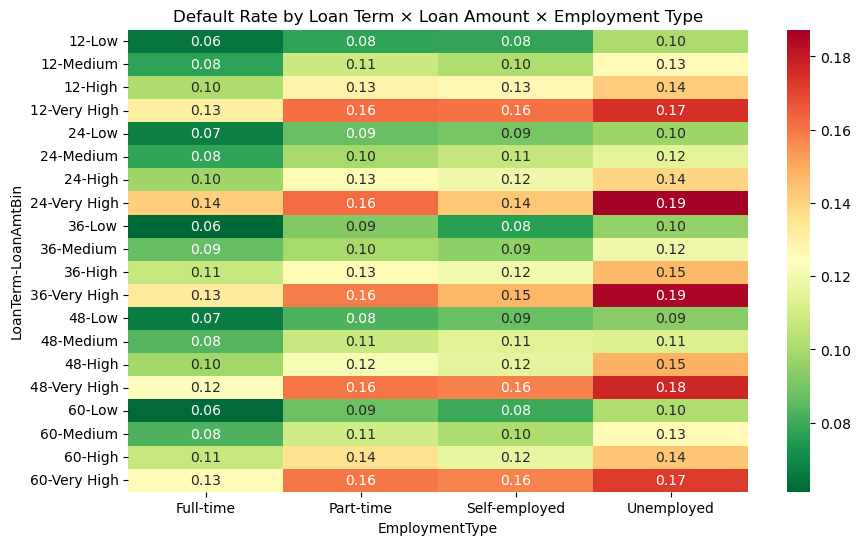

In [89]:
# Bin loan amounts into categories for readability
df['LoanAmtBin'] = pd.qcut(df['LoanAmount'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Group by Loan Term, LoanAmtBin, EmploymentType
term_amt_emp = df.groupby(['LoanTerm', 'LoanAmtBin', 'EmploymentType'])['Default'].mean().reset_index()

# Pivot for heatmap
pivot_term_amt_emp = term_amt_emp.pivot_table(
    values='Default', index=['LoanTerm', 'LoanAmtBin'], columns='EmploymentType'
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot_term_amt_emp, annot=True, cmap="RdYlGn_r", fmt=".2f")
plt.title("Default Rate by Loan Term × Loan Amount × Employment Type")
plt.show()


# Feature Engineering

Creating new features based on our EDA.  

1. **Loan-to-Income Ratio** – captures how large the loan is compared to income.  
2. **Loan Term in Years** – convert months → years for interpretability.  
3. **Age Groups** – bucket ages into categories.  
4. **Loan Amount Bins** – split into quartiles.  
5. **Encoding** – categorical → OneHot, numeric → StandardScaler.  


In [420]:
from sklearn.preprocessing import FunctionTransformer

def feature_engineering(df):
    df = df.copy()
    df['LoanIncomeRatio'] = df['LoanAmount'] / df['Income']
    df['LoanTermYears'] = df['LoanTerm'] / 12
    df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 25, 35, 50, 65, 100],
                            labels=['18-25', '26-35', '36-50', '51-65', '65+'])
    df['LoanAmtBin'] = pd.qcut(df['LoanAmount'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    df['LoanTerm_Employment'] = df['LoanTerm'].astype(str) + "_" + df['EmploymentType'].astype(str)
    df['LoanAmtBin_Employment'] = df['LoanAmtBin'].astype(str) + "_" + df['EmploymentType'].astype(str)
    df['LoanTerm_LoanAmtBin'] = df['LoanTerm'].astype(str) + "_" + df['LoanAmtBin'].astype(str)
    
    # If 'CreditScoreCategory' exists, create it similarly (add here if used)
    return df

# Wrap in a FunctionTransformer
feature_transformer = FunctionTransformer(feature_engineering)


### Encoding & Splitting Data

We separate features (X) and target (y),  
then encode categorical features and scale numeric ones.


In [236]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Update numeric and categorical lists
numeric_features = [
    'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
    'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'LoanIncomeRatio'
]

categorical_features = [
    'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 
    'LoanPurpose', 'HasCoSigner', 'AgeGroup', 'CreditScoreCategory', 'LoanTerm_Employment', 
    'LoanAmtBin_Employment', 'LoanTerm_LoanAmtBin'
]

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## 1. Baseline Model: Logistic Regression

We start with Logistic Regression as our baseline classifier.  
- Advantages: Simple, interpretable, fast.  
- Goal: Establish a benchmark accuracy and see if features (especially categorical + engineered ones) contribute to prediction.  
- Logistic Regression works well with scaled numeric features and one-hot encoded categorical features, so we will use our preprocessor pipeline.


In [239]:
print("Numeric:", numeric_features,"\n")
print("Categorical:", categorical_features,"\n")

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Define X and y AFTER feature engineering
X = df[numeric_features + categorical_features]
y = df['Default']   

# Train-test split (70-30 with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)



Numeric: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'LoanIncomeRatio'] 

Categorical: ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'AgeGroup', 'CreditScoreCategory', 'LoanTerm_Employment', 'LoanAmtBin_Employment', 'LoanTerm_LoanAmtBin'] 

set()


In [241]:
X = df[numeric_features + categorical_features]
y = df['Default']  # target

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)



In [227]:
# --- Logistic Regression pipeline ---
logreg_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, solver='liblinear'))
])

# --- Fit the model ---
logreg_clf.fit(X_train, y_train)

# --- Predictions & Evaluation ---
y_pred = logreg_clf.predict(X_test)
y_proba = logreg_clf.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     67681
           1       0.61      0.07      0.13      8893

    accuracy                           0.89     76574
   macro avg       0.75      0.53      0.53     76574
weighted avg       0.86      0.89      0.85     76574

Confusion Matrix:
 [[67285   396]
 [ 8267   626]]
ROC-AUC: 0.7618313698026835


**Interpretation:**

- The model predicts non-defaulters (class 0) very well, but struggles to correctly identify defaulters (class 1).  
- High recall for class 0 but very low recall for class 1 indicates the model is biased toward predicting non-default.  
- ROC-AUC of 0.76 suggests moderate discriminative power between defaulters and non-defaulters.  

This indicates that while the model has good overall accuracy, it may need further tuning or additional features to improve detection of defaulters.


### Loan Risk Scoring

Since this system is used to evaluate loan risk, we use the **predicted probability of default** from our Logistic Regression model as a **risk score**.  

- Higher probability → higher risk  
- This allows the bank/organization to prioritize which loans are more likely to default.  

We'll also segment loans into risk tiers: **Low, Medium, High**.


In [257]:
# Convert predicted probabilities into a risk score
risk_scores = y_proba  # probability of default

# Add risk score to a DataFrame for clarity
risk_df = X_test.copy()
risk_df['Default_Prob'] = risk_scores
risk_df['Actual_Default'] = y_test.values

# Segment into risk categories
bins = [0, 0.3, 0.6, 1.0]
labels = ['Low Risk', 'Medium Risk', 'High Risk']
risk_df['RiskCategory'] = pd.cut(risk_df['Default_Prob'], bins=bins, labels=labels)

# Quick check
risk_df[['Default_Prob', 'RiskCategory', 'Actual_Default']].head()


,Default_Prob,RiskCategory,Actual_Default
159333,0.177181,Low Risk,0
83695,0.207463,Low Risk,0
125419,0.096228,Low Risk,0
12336,0.167751,Low Risk,0
109131,0.085620,Low Risk,0


### Visualizing Risk Scores

We can visualize the distribution of predicted risk scores and see how they correlate with actual defaults.


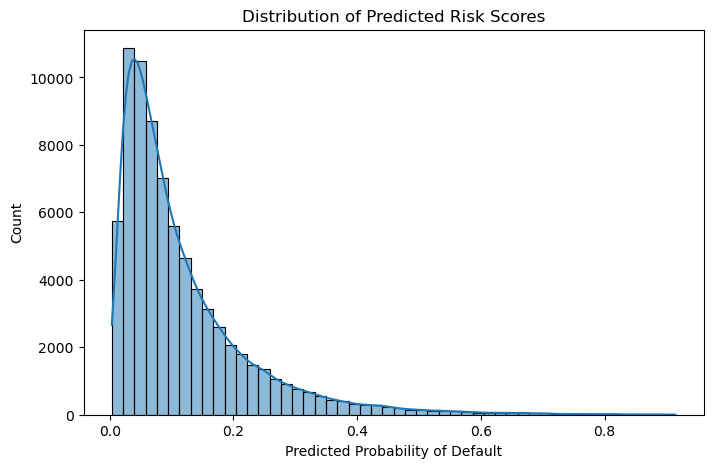

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(risk_df['Default_Prob'], bins=50, kde=True)
plt.title("Distribution of Predicted Risk Scores")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Count")
plt.show()

In [262]:
# Count defaults per risk category
risk_summary = risk_df.groupby('RiskCategory')['Actual_Default'].agg(['count','sum'])
risk_summary.rename(columns={'count':'Total Loans','sum':'Actual Defaults'}, inplace=True)
risk_summary['Default Rate'] = risk_summary['Actual Defaults'] / risk_summary['Total Loans']

risk_summary


,Total Loans,Actual Defaults,Default Rate
RiskCategory,,,
Low Risk,71410,6662,0.093292
Medium Risk,4699,1907,0.405831
High Risk,465,324,0.696774


## Random Forest Classifier

Random Forest is an ensemble learning method that combines multiple decision trees to improve predictive performance and reduce overfitting. 
We will use the same preprocessed features as for Logistic Regression.


In [267]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Fit the model
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     67681
           1       0.61      0.04      0.07      8893

    accuracy                           0.89     76574
   macro avg       0.75      0.52      0.51     76574
weighted avg       0.86      0.89      0.84     76574

Confusion Matrix:
 [[67454   227]
 [ 8540   353]]
ROC-AUC: 0.734038505355455


### Random Forest Results

- **Classification Report**: 
  - Non-defaulters (0) are predicted very well (precision 0.89, recall 1.0).  
  - Defaulters (1) are detected poorly (recall only 0.04), meaning most defaulters are missed.  
  - F1-score is low for defaulters (0.07), indicating imbalance in prediction.
    

- **Confusion Matrix**: 
  - True Negatives (TN): 67454 → correctly predicted non-defaulters.
  - False Positives (FP): 227 → non-defaulters predicted as defaulters.
  - False Negatives (FN): 8540 → defaulters missed.
  - True Positives (TP): 353 → defaulters correctly predicted.

- **ROC-AUC**: 0.734 → model has moderate ability to distinguish between defaulters and non-defaulters.

**Conclusion**: Random Forest improves detection slightly over Logistic Regression in separating defaulters vs. non-defaulters, but the recall for defaulters is still very low due to class imbalance. This indicates we may need to handle imbalance (e.g., with oversampling, undersampling, or class weights) to improve defaulter detection.


### XGBoost Classifier

XGBoost is used to handle imbalanced datasets better and capture non-linear relationships. We'll use the same features and preprocessing pipeline as before.


In [277]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# XGBoost Pipeline
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200, 
        max_depth=5, 
        learning_rate=0.1, 
        scale_pos_weight=10,  # approximate imbalance ratio
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Fit the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75     67681
           1       0.21      0.75      0.32      8893

    accuracy                           0.63     76574
   macro avg       0.58      0.68      0.54     76574
weighted avg       0.86      0.63      0.70     76574

Confusion Matrix:
 [[41729 25952]
 [ 2194  6699]]
ROC-AUC: 0.7550381027999148


### XGBoost Classifier Results

**Observations:**

- **Recall for defaulters (class 1)** is significantly improved (~0.75), meaning the model catches 75% of actual defaults.  
- **Precision for defaulters** is low (~0.21), so some non-defaulters are incorrectly flagged.  
- **Overall accuracy** is 0.63, which is lower than Random Forest, but this is expected due to imbalanced data.  
- **ROC-AUC** is ~0.76, showing decent separability between defaulters and non-defaulters.  
- **Confusion Matrix** highlights that XGBoost is prioritizing catching defaults over exact classification of non-defaulters, which is useful for risk scoring.

**Conclusion:**  
XGBoost is better for identifying high-risk loans (defaulters) due to higher recall, even though overall accuracy is lower. This aligns with our objective of predicting potential defaults effectively.


### Combining Random Forest and XGBoost Models using Voting Classifier


In [362]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Define individual classifiers
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=10,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Voting classifier (soft voting uses predicted probabilities)
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='soft',  # uses predicted probabilities
    n_jobs=-1
)

# Pipeline with preprocessing
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble_clf)
])

# Fit the ensemble
ensemble_pipeline.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:59:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio',
                                                   'LoanIncomeRatio']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Education',
                                                   'Employment...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                  n_jobs=-1, voting='soft'))])

### Ensemble Model Evaluation & Risk Scoring

We evaluate the **Random Forest + XGBoost Voting Classifier** using predicted probabilities. 
A threshold is chosen to classify defaults (1) vs non-defaults (0). 
We then assign **risk categories** (Low, Medium, High) based on the predicted default probabilities to help prioritize high-risk loans.


In [397]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# Predicted probability of default (class 1)
y_proba_ensemble = ensemble_pipeline.predict_proba(X_test)[:,1]

# Threshold for classifying 1/0 (adjustable based on business needs)
threshold = 0.3
y_pred_ensemble = (y_proba_ensemble >= threshold).astype(int)

# Classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_ensemble))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.60      0.74     67681
           1       0.20      0.76      0.32      8893

    accuracy                           0.62     76574
   macro avg       0.58      0.68      0.53     76574
weighted avg       0.86      0.62      0.69     76574

Confusion Matrix:
 [[40578 27103]
 [ 2091  6802]]
ROC-AUC: 0.7547424227791226


### Risk Category Assignment

We define risk categories based on the predicted probability:
- **Low Risk**: prob < 0.1  
- **Medium Risk**: 0.1 ≤ prob < 0.3  
- **High Risk**: prob ≥ 0.3  

This helps in grouping loans by risk and calculating default rates per category.


In [400]:
# Function to assign risk categories
def assign_risk(prob):
    if prob < 0.1:
        return 'Low Risk'
    elif prob < 0.3:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Assign risk categories
risk_df = X_test.copy()
risk_df['Default_Prob'] = y_proba_ensemble
risk_df['Actual_Default'] = y_test.values
risk_df['RiskCategory'] = risk_df['Default_Prob'].apply(assign_risk)

# Summary table by risk category
risk_summary = risk_df.groupby('RiskCategory').agg(
    Total_Loans=('Actual_Default', 'count'),
    Actual_Defaults=('Actual_Default', 'sum')
)
risk_summary['Default_Rate'] = risk_summary['Actual_Defaults'] / risk_summary['Total_Loans']
risk_summary


,Total_Loans,Actual_Defaults,Default_Rate
RiskCategory,,,
High Risk,33905,6802,0.200619
Low Risk,5979,97,0.016223
Medium Risk,36690,1994,0.054347


### Deciding Threshold

In [395]:
y_proba_ensemble = ensemble_pipeline.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for thresh in thresholds:
    print(f"\n--- Threshold: {thresh} ---")
    y_pred_thresh = (y_proba >= thresh).astype(int)
    print("Classification Report:\n", classification_report(y_test, y_pred_thresh))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

def risk_bucket(prob):
    if prob >= 0.6:
        return 'High Risk'
    elif prob >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df_test = X_test.copy()
df_test['Default_Prob'] = y_proba
df_test['RiskCategory'] = df_test['Default_Prob'].apply(risk_bucket)
df_test['Actual_Default'] = y_test.values

# Aggregate
risk_summary = df_test.groupby('RiskCategory').agg(
    Total_Loans=('Actual_Default', 'count'),
    Actual_Defaults=('Actual_Default', 'sum')
)
risk_summary['Default_Rate'] = risk_summary['Actual_Defaults'] / risk_summary['Total_Loans']
print(risk_summary)



--- Threshold: 0.3 ---
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.39      0.55     67681
           1       0.16      0.89      0.27      8893

    accuracy                           0.45     76574
   macro avg       0.56      0.64      0.41     76574
weighted avg       0.87      0.45      0.52     76574

Confusion Matrix:
 [[26241 41440]
 [  946  7947]]
ROC-AUC: 0.7607538737665621

--- Threshold: 0.4 ---
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.55      0.70     67681
           1       0.19      0.81      0.31      8893

    accuracy                           0.58     76574
   macro avg       0.57      0.68      0.50     76574
weighted avg       0.87      0.58      0.65     76574

Confusion Matrix:
 [[37259 30422]
 [ 1703  7190]]
ROC-AUC: 0.7607538737665621

--- Threshold: 0.5 ---
Classification Report:
               precision    recall  f1-score   

## Model Export

In [408]:
joblib.dump(ensemble_clf, 'model.pkl')
print("Model saved!")

Model saved!


In [416]:
joblib.dump(preprocessor, 'preprocessor.pkl')
print("preprocessor saved!")

preprocessor saved!


In [424]:
full_pipeline = Pipeline([
    ('feature_engineering', feature_transformer),
    ('preprocessor', preprocessor),
    ('classifier', ensemble_clf)
])

full_pipeline.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:05:29] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x1755ca520>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio',
                                                   'LoanIncomeRatio']),
                                                 ('cat'...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                  n_jobs=-1, voting='soft'))])

In [426]:
joblib.dump(full_pipeline, 'model1.pkl')
print("Model saved!")

Model saved!
